# 🐶🐺 Dogs vs Wolves Classification using ResNet50 (PyTorch)

## 0. Setup and Imports

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import transforms, models, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
from PIL import Image, ImageFile
import os
import matplotlib.pyplot as plt
import seaborn as sns

ImageFile.LOAD_TRUNCATED_IMAGES = True

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## 1. Data Transforms

In [24]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

## 2. Load Dataset and Create Train/Test Split

In [25]:
def create_train_test_loaders(data_dir, batch_size=32, test_split=0.2):
    full_dataset = datasets.ImageFolder(root=data_dir)
    class_names = full_dataset.classes
    print(f"Classes found: {class_names}")
    targets = [label for _, label in full_dataset.samples]

    train_idx, test_idx = train_test_split(list(range(len(full_dataset))), test_size=test_split, random_state=42, stratify=targets)

    train_dataset = datasets.ImageFolder(root=data_dir, transform=train_transform)
    test_dataset = datasets.ImageFolder(root=data_dir, transform=test_transform)

    train_subset = Subset(train_dataset, train_idx)
    test_subset = Subset(test_dataset, test_idx)

    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader, class_names

## 3. Create ResNet50 Model

In [26]:
def create_resnet50_model(num_classes=2):
    model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
    for param in model.parameters():
        param.requires_grad = False
    num_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(num_features, 512), nn.ReLU(), nn.Dropout(0.4),
        nn.Linear(512, 256), nn.ReLU(), nn.Dropout(0.3),
        nn.Linear(256, num_classes)
    )
    return model.to(device)

## 4. Training Function

In [27]:
def train_model(model, train_loader, test_loader, num_epochs=15):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

    history = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': []}
    best_acc = 0.0

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

        train_acc = 100 * correct / total
        train_loss = running_loss / len(train_loader)

        model.eval()
        test_loss, correct, total = 0, 0, 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (preds == labels).sum().item()
        test_acc = 100 * correct / total

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['test_loss'].append(test_loss / len(test_loader))
        history['test_acc'].append(test_acc)

        print(f"Epoch {epoch+1}/{num_epochs} | Train Acc: {train_acc:.2f}% | Test Acc: {test_acc:.2f}%")

        if test_acc > best_acc:
            best_acc = test_acc
            torch.save(model.state_dict(), 'best_resnet50_dogs_wolves.pth')
            print("✓ Best model saved")

        scheduler.step()
    return history

## 5. Evaluation and Confusion Matrix

In [28]:
def evaluate_model(model, test_loader, class_names):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.numpy())
            y_pred.extend(preds.cpu().numpy())

    print(classification_report(y_true, y_pred, target_names=class_names))
    cm = confusion_matrix(y_true, y_pred)

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

## 6. Plot Training History

In [29]:
def plot_training_history(history):
    epochs = range(1, len(history['train_loss']) + 1)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], 'b-', label='Train Loss')
    plt.plot(epochs, history['test_loss'], 'r-', label='Test Loss')
    plt.legend(); plt.title('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], 'b-', label='Train Acc')
    plt.plot(epochs, history['test_acc'], 'r-', label='Test Acc')
    plt.legend(); plt.title('Accuracy')

    plt.show()

## 7. Predict a Single Image

In [30]:
def predict_with_probabilities(model, image_path, class_names):
    model.eval()
    image = Image.open(image_path).convert('RGB')
    image_tensor = test_transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = model(image_tensor)
        probs = torch.nn.functional.softmax(outputs, dim=1)[0].cpu().numpy()

    for cls, p in zip(class_names, probs):
        print(f"{cls}: {p*100:.2f}%")
    print("Predicted:", class_names[np.argmax(probs)])

## 8. Helper Function: Test a Single Image After Training

In [31]:
def test_single_image(model_path, image_path, class_names=['dogs', 'wolves']):
    model = create_resnet50_model(num_classes=len(class_names))
    model.load_state_dict(torch.load(model_path, map_location=device))
    predict_with_probabilities(model, image_path, class_names)

## 9. Main Execution

Classes found: ['dogs', 'wolves']
Epoch 1/15 | Train Acc: 87.18% | Test Acc: 95.67%
✓ Best model saved
Epoch 2/15 | Train Acc: 94.13% | Test Acc: 97.04%
✓ Best model saved
Epoch 3/15 | Train Acc: 96.30% | Test Acc: 94.31%
Epoch 4/15 | Train Acc: 94.70% | Test Acc: 94.31%
Epoch 5/15 | Train Acc: 95.44% | Test Acc: 97.49%
✓ Best model saved
Epoch 6/15 | Train Acc: 96.92% | Test Acc: 97.49%
Epoch 7/15 | Train Acc: 95.90% | Test Acc: 97.49%
Epoch 8/15 | Train Acc: 96.35% | Test Acc: 97.95%
✓ Best model saved
Epoch 9/15 | Train Acc: 96.81% | Test Acc: 97.72%
Epoch 10/15 | Train Acc: 96.47% | Test Acc: 97.72%
Epoch 11/15 | Train Acc: 96.07% | Test Acc: 97.95%
Epoch 12/15 | Train Acc: 96.41% | Test Acc: 97.49%
Epoch 13/15 | Train Acc: 96.92% | Test Acc: 97.27%
Epoch 14/15 | Train Acc: 96.58% | Test Acc: 97.72%
Epoch 15/15 | Train Acc: 96.70% | Test Acc: 97.72%
              precision    recall  f1-score   support

        dogs       0.98      0.97      0.98       220
      wolves       0.97  

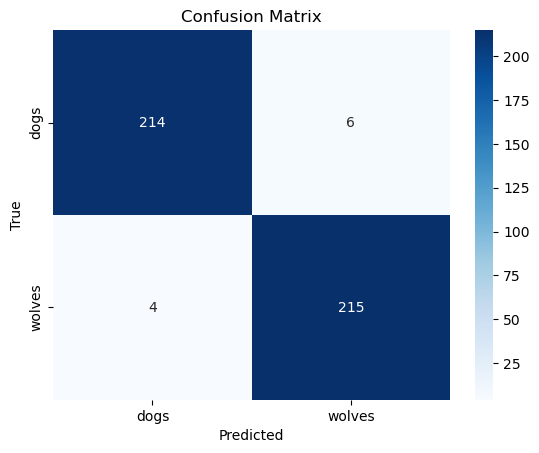

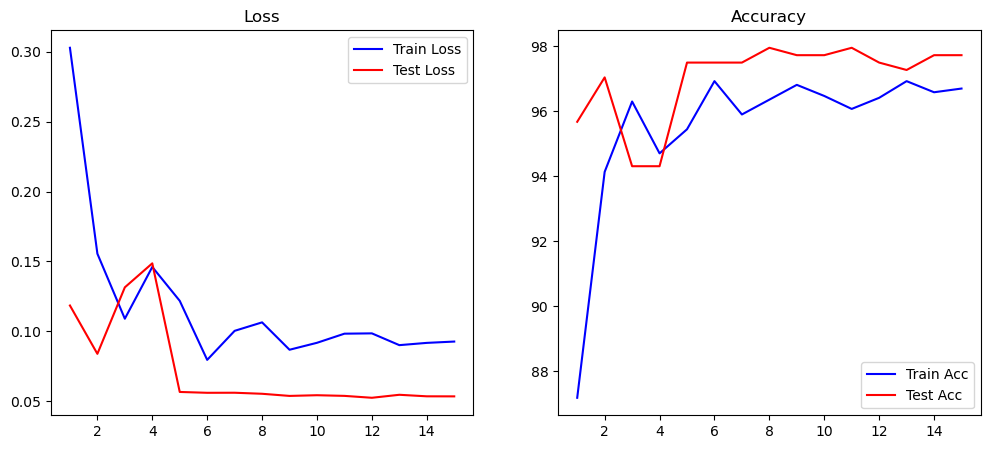

In [32]:
def main():
    DATA_DIR = 'dataset'
    BATCH_SIZE = 32
    NUM_EPOCHS = 15

    train_loader, test_loader, class_names = create_train_test_loaders(DATA_DIR, BATCH_SIZE)
    model = create_resnet50_model(num_classes=len(class_names))
    history = train_model(model, train_loader, test_loader, NUM_EPOCHS)
    evaluate_model(model, test_loader, class_names)
    plot_training_history(history)

main()

## 10. Test a Single Image After Training

In [38]:
# Example usage (after training completes):
test_single_image('best_resnet50_dogs_wolves.pth', 'dataset/dog_test.jpeg')

dogs: 2.04%
wolves: 97.96%
Predicted: wolves
